<a href="https://colab.research.google.com/github/OBulun/AN2DL_CH_2/blob/Francesco/v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**

In [ ]:
from google.colab import drive
drive.mount("/gdrive")
# Define current_dir correctly for Python (no backslashes for spaces)
current_dir = "/gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2"
# Use the correctly formatted path for the %cd magic command, quoting it for safety
%cd "$current_dir"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2


## 1. Import Libraries

In [ ]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader

# Install torchview
!pip install torchview
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cpu


## **2. Data Loading**

In [ ]:
# Assume datasets are in the current working directory, which is now correctly formatted.
datasets_path = current_dir

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")

test_data_path = os.path.join(datasets_path, "test_data")

output_path = os.path.join(datasets_path, "train_masked")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path             # Folder containing img_xxxx and mask_xxxx
OUTPUT_FOLDER = output_path                 # Where the resized and masked images will be saved

TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: /gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2
Train data path: /gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2/train_data
Train labels path: /gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2/train_labels.csv
Test data path: /gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2/test_data
Output path: /gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2/train_masked


In [ ]:
def apply_mask(image_path, mask_path, output_path, target_size=(224, 224)):
    """
    Loads an image and a mask, resizes them, applies the mask, and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        # Resize image using linear interpolation (better for photos)
        img = cv2.resize(img, target_size)
        # Resize mask using nearest neighbor to preserve sharp edges
        mask = cv2.resize(mask, target_size)

    # 4. Ensure mask is strictly binary (0 or 255)
    # Values > 127 become 255 (White), others become 0 (Black)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Apply the mask
    # cv2.bitwise_and keeps the pixel where the mask is 255, and makes it 0 where mask is 0
    masked_img = cv2.bitwise_and(img, img, mask=binary_mask)

    # 6. Save result
    cv2.imwrite(str(output_path), masked_img)

In [ ]:
def process_batch(input_dir, output_dir, target_size=(224, 224)):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx',
    resizes them to target_size, and saves the masked result to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)

    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir()
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]

    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0

    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct expected mask filename: img_123.jpg -> mask_123.jpg
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name

        # Fallback: If mask_123.jpg doesn't exist, try mask_123.png
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")

        if mask_path.exists():
            output_path = output_dir / file_path.name

            if output_path.exists():
                # Skip silently
                continue

            apply_mask(file_path, mask_path, output_path, target_size=target_size)
            count += 1
        else:
            # Use tqdm.write to log errors without breaking the progress bar
            tqdm.write(f"Skipping {file_path.name}: No matching mask found (looked for {mask_name})")

    print(f"Batch processing complete. Processed {count} new images.")

In [ ]:
def load_images_from_folder(folder):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        np.ndarray: Array of preprocessed images with shape (N, H, W, C)
    """
    images = []

    # Get the list of files to iterate over
    file_list = os.listdir(folder)

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        #NOTE: commented out because the images are already resized
        # Crop the image to be square
        # dim = min(img.shape[:2])
        # start_y = (img.shape[0] - dim) // 2
        # start_x = (img.shape[1] - dim) // 2
        # img = img[start_y:start_y+dim, start_x:start_x+dim, :]

        # NOTE: commented out because the images are already resized
        # Resize the image to 224x224 pixels
        # img = cv2.resize(img, (224, 224))

        images.append(img)

    return np.array(images)

In [ ]:
process_batch(SOURCE_FOLDER, OUTPUT_FOLDER, target_size=TARGET_SIZE)
MASKED_IMAGE_PATH = OUTPUT_FOLDER

Scanning for images in: /gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2/train_data...


Processing Images: 100%|██████████| 1412/1412 [00:01<00:00, 970.03img/s] 

Batch processing complete. Processed 0 new images.


In [ ]:
train_images = load_images_from_folder(MASKED_IMAGE_PATH)
print(f"Loaded {len(train_images)}  images")

Loading images from train_masked: 100%|██████████| 1412/1412 [00:36<00:00, 38.29it/s]


Loaded 1412  images


## **3. Exploration and Data Analysis**

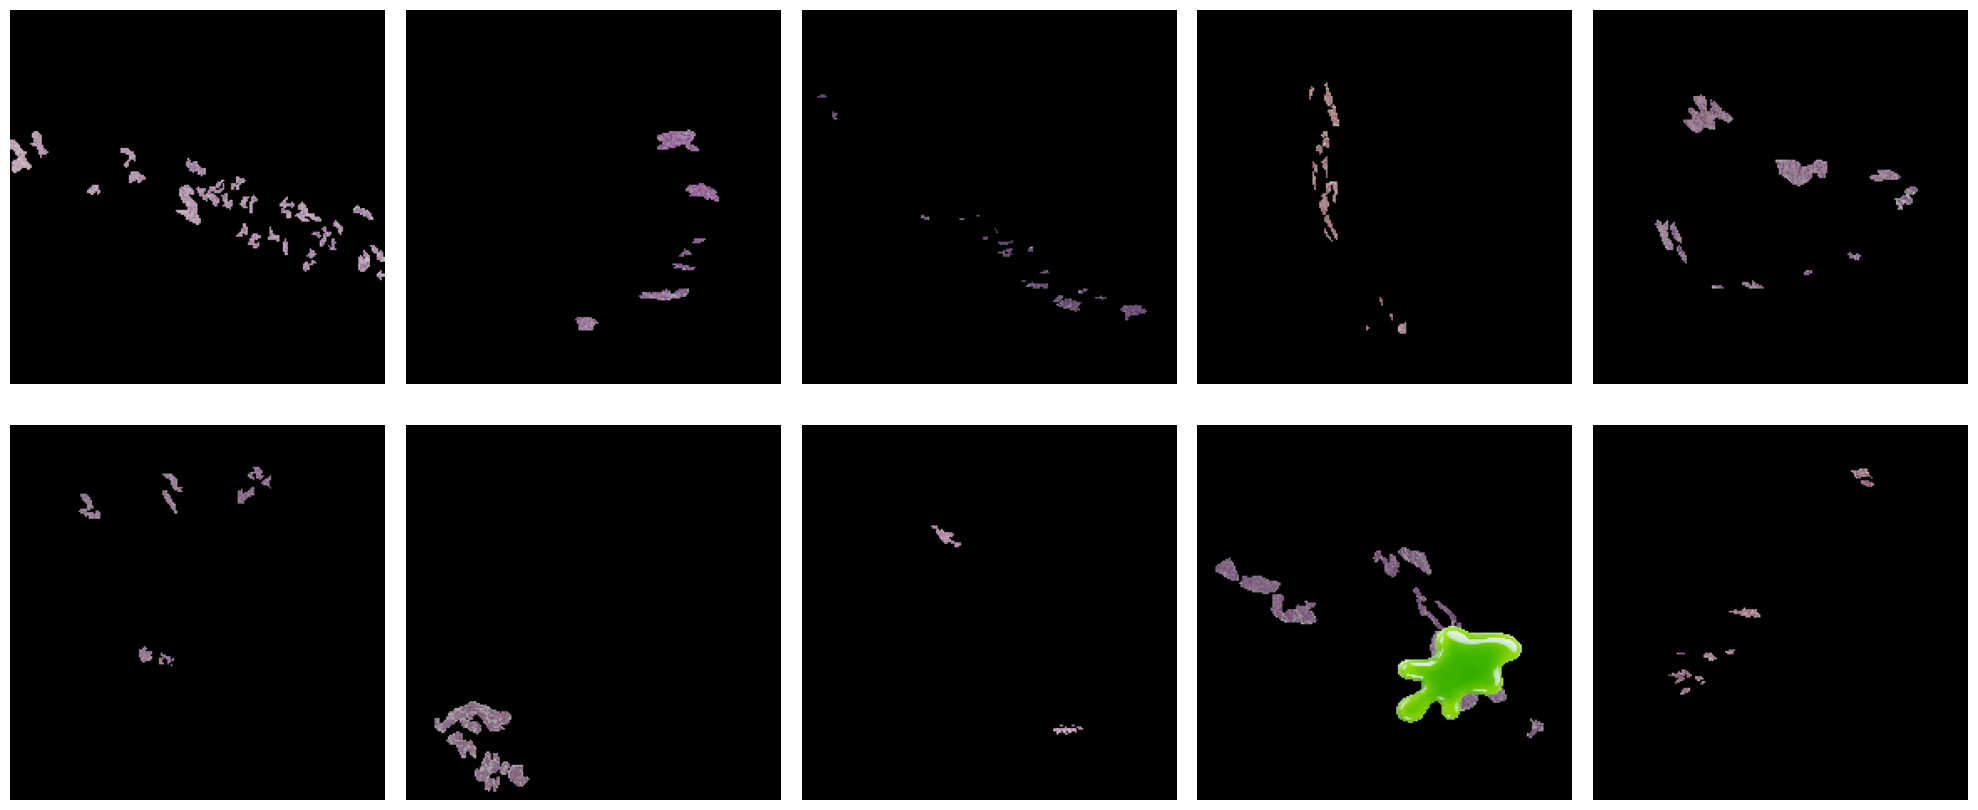

In [ ]:
# Number of images to display
num_img = 10
start_img= 120
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def detect_green_outliers(img, show=True):
    """
    img: immagine RGB in formato numpy (0-1 o 0-255)
    return: green_mask (0/1)
    """

    # Assicuriamoci che sia in formato 0-255 uint8 per OpenCV
    if img.max() <= 1.0:
        img_255 = (img * 255).astype(np.uint8)
    else:
        img_255 = img.astype(np.uint8)

    # Convertiamo in HSV
    hsv = cv2.cvtColor(img_255, cv2.COLOR_RGB2HSV)

    # --- Range per il verde acceso ---
    lower_green = np.array([35, 120, 120])
    upper_green = np.array([85, 255, 255])

    # Maschera binaria
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Opzionale: pulizia della maschera
    kernel = np.ones((5, 5), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    if show:
        # Highlights in rosso
        highlighted = img_255.copy()
        highlighted[mask_clean > 0] = [255, 0, 0]

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(img_255)
        ax[0].set_title("Originale")
        ax[0].axis("off")

        ax[1].imshow(mask_clean, cmap='gray')
        ax[1].set_title("Maschera verde")
        ax[1].axis("off")

        ax[2].imshow(highlighted)
        ax[2].set_title("Zone verdi evidenziate")
        ax[2].axis("off")

        plt.show()

    return mask_clean

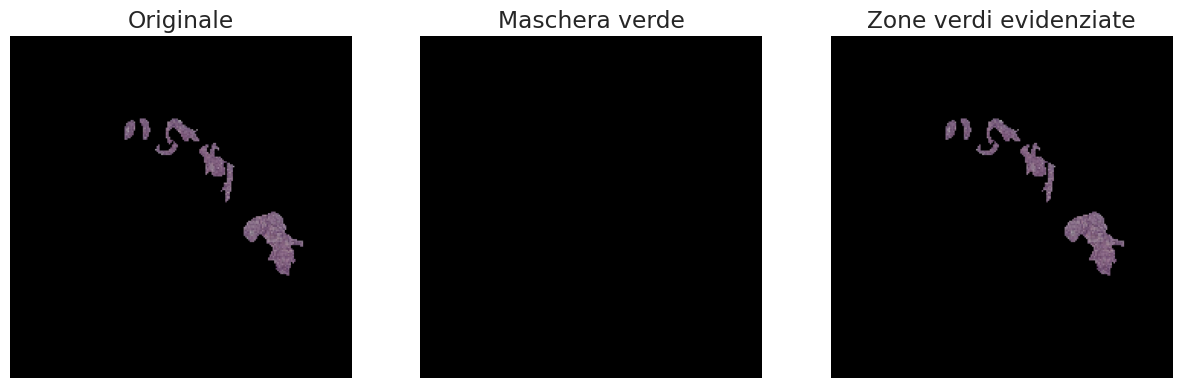

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
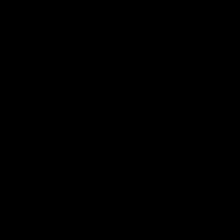

In [ ]:
detect_green_outliers(train_images[105])

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Load the labels CSV
labels_df = pd.read_csv(train_labels_path)
# Create a dictionary mapping filename -> label for fast lookup
labels_map = dict(zip(labels_df.iloc[:, 0], labels_df.iloc[:, 1]))

# 2. Get the filenames corresponding to the images loaded in Cell 7
# IMPORTANT: This must match the order used in 'load_images_from_folder' exactly.
# We re-read the file list to ensure we have the specific names associated with the indices of 'train_images'
filenames = os.listdir(MASKED_IMAGE_PATH)

print("Aligning labels to loaded images...")

X_aligned = []
y_aligned = []

# 3. Iterate through the filenames to sync X (images) and y (labels)
# We assume 'train_images' matches the order of 'filenames' because they rely on the same os.listdir call order
# provided no files were added/deleted between Cell 7 and Cell 9.
if len(filenames) != len(train_images):
    raise ValueError(f"Mismatch! Loaded images ({len(train_images)}) != Files found ({len(filenames)}).")

for i, filename in enumerate(filenames):
    if filename in labels_map:
        # If the file exists in our CSV, keep the image and the label
        X_aligned.append(train_images[i])
        y_aligned.append(labels_map[filename])
    else:
        # If image is in folder but NOT in CSV, we must discard the image
        print(f"Skipping {filename}: Image found but no label in CSV.")

# Convert to numpy arrays
X = np.array(X_aligned)
y = np.array(y_aligned)

print(f"Images aligned: {X.shape}")
print(f"Labels aligned: {y.shape}")

# 4. Encode labels (String -> Integer)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print class mapping
print("Classes:", label_encoder.classes_)

# 5. Train-Test Split (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=SEED,
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")

Aligning labels to loaded images...
Images aligned: (1412, 224, 224, 3)
Labels aligned: (1412,)
Classes: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Training data shape: (1129, 224, 224, 3), Labels: (1129,)
Validation data shape: (141, 224, 224, 3), Labels: (141,)
Test data shape: (142, 224, 224, 3), Labels: (142,)


In [ ]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


In [ ]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds = TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2),
    torch.from_numpy(y_train).squeeze().long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2),
    torch.from_numpy(y_val).squeeze().long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2),
    torch.from_numpy(y_test).squeeze().long()
)

In [ ]:
# Define the batch size
BATCH_SIZE = 32

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

Features batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
